# Fig. 9

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import xarray as xr 
import seaborn as sns

plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 20})

import warnings
warnings.filterwarnings("ignore")


## Funtions 

In [2]:
def another_mask(ds, cutoff, dlat=0.3, dlon=0.5, use_tracer=True):
    """
    Applies a mask to the dataset based on latitude, longitude, and a threshold quantile height.

    Parameters:
    ds (xarray.Dataset): The dataset to be masked.
    cutoff (float): The threshold factor for determining the mask.
    dlat (float): The latitude range around -36° for the mask (default is 0.3).
    dlon (float): The longitude range around 146.5° for the mask (default is 0.5).
    use_tracer (bool): If True, use the "Qpassive_1" tracer for calculation; otherwise, use density (default is True).

    Returns:
    xarray.Dataset: The dataset with an additional 'ao_mask' variable.
    """
    # Apply the initial geographical mask based on latitude and longitude
    ds_masked = ds.where(
        (ds.lat >= -36 - dlat) & (ds.lat <= -36 + dlat) & 
        (ds.lon >= 146.5 - dlon) & (ds.lon <= 146.5 + dlon),
        other=np.nan
    )

    # Apply the mask based on quantile height (5th percentile)
    ds_masked2 = ds_masked.where(
        ds.height > quantile_height(ds, quantile=0.05),
        other=np.nan
    )

    # Calculate flux based on the tracer or density
    if use_tracer:
        qflux = ds_masked2["w_intp"] * ds_masked2["Qpassive_1"]
    else:
        qflux = ds_masked2["w_intp"] * dens(ds_masked2)

    # Determine the maximum flux and apply the cutoff factor
    qmax = qflux.max(("lon", "lat"))
    threshold = qmax * cutoff
    aomask = qflux > threshold

    # Assign the mask to the dataset
    ds['ao_mask'] = (("time", "height", "lat", "lon"), aomask.data)

    return ds

def quantile_height(ds, var="Qpassive_1", quantile=0.05):
    """
    Calculates the height above which a specified quantile percentage of the given variable are located.
    Primarily used with 'Qpassive_1' to determine the injection height.

    Parameters:
    ds (xarray.Dataset): The dataset containing the variable of interest.
    var (str): The variable name to use for calculation (default is "Qpassive_1").
    quantile (float): The quantile value (e.g., 0.05 for 5%) to determine the height threshold (default is 0.05).

    Returns:
    xarray.DataArray: The minimum height where the specified quantile condition is met.
    """
    
    ds = ds.mean(("lat", "lon"))
    rho = dens(ds)
    dz = -1 * z.differentiate("height")
    qplume = ds[var] * rho.values * dz.values
    qplume_sum = qplume.cumsum(dim="height")
    qplume_100 = qplume_sum.max(dim="height")
    qplume_q = qplume_100 * quantile
    height_q = ds['height'].where(qplume_q < qplume_sum)
    height_q_min = height_q.min(dim="height")

    return height_q_min


def dens(d): 
    R = 287.1
    densitiy = d.pres / (R * d.temp)
    return densitiy



def cloud_base(dset):
    """
    Finds the cloud base height where the 'qc' variable exceeds a certain threshold.

    Parameters:
    dset (xarray.Dataset): The dataset containing the 'qc' variable and a mask called 'inner_mask'.

    Returns:
    xarray.DataArray: The height at which 'qc' exceeds the threshold.
    """
    # Apply the mask to the dataset
    dset = dset.where(dset.inner_mask, np.nan)

    # Calculate the mean across the 'lon' and 'lat' dimensions
    data = dset.mean(("lon", "lat"))

    # Find 'qc' values that exceed the threshold (0.0002)
    qc_above_threshold = data['qc'].where(data['qc'] > 0.0002).values

    # Find the indices where 'qc' is not NaN
    valid_indices = np.where(~np.isnan(qc_above_threshold))

    # Find the highest valid index for the cloud base
    if valid_indices[0].size > 0:  # Ensure there is a valid index
        highest_index = np.max(valid_indices)
        highest_height = dset.height.isel(height=highest_index)
    else:
        highest_height = np.nan  # Return NaN if no valid index is found

    return highest_height



def more_vars(ds):
    """
    Calculates additional thermodynamic variables and adds them to the dataset.

    Parameters:
    ds (xarray.Dataset): The dataset containing temperature and water vapor data.

    Returns:
    xarray.Dataset: The original dataset with additional variables for analysis.
    """
    # Constants for calculations
    p0 = 100000  # Reference pressure in hPa
    lv_const_a = 2500.78  # Latent heat constant (a)
    lv_const_b = 2.32573  # Latent heat constant (b)
    Rd = 287.04  # Specific gas constant for dry air (J/(kg·K))
    cp = 1004.82  # Specific heat capacity at constant pressure (J/(kg·K))
    cw = 4186.74  # Specific heat capacity of water (J/(kg·K))

    # Calculate the mixing ratio of water vapor
    r = ds.qv / (1 - ds.qv)

    # Calculate the latent heat of vaporization (lv)
    lv = lv_const_a - (ds.temp * lv_const_b)

    # Calculate equivalent potential temperature (theta_ae)
    theta_ae = (ds.temp + r * (lv / (cp + r * cw))) * ((p0 / ds.pres) ** (Rd / cp))
    ds["theta_ae"] = theta_ae

    # Calculate potential temperature (tpot)
    tpot = ds.temp * ((p0 / ds.pres) ** (Rd / cp))
    ds["tpot"] = tpot

    # Add the mixing ratio as a variable to the dataset
    ds["r"] = r

    # Calculate and add density to the dataset
    ds["dens"] = dens(ds)

    # Calculate total water content and condensed water content
    ds["qtotal"] = ds.qc + ds.qi + ds.qg + ds.qs + ds.qh + ds.qr + ds.qv
    ds["qcondens"] = ds.qc + ds.qi + ds.qg + ds.qs + ds.qh + ds.qr

    return ds

In [3]:
def override_height(ds, z):
    return ds.assign_coords(height=z.values)

## Get Data

In [4]:
data_path = "../data/"
dsref = xr.open_mfdataset(data_path + "exp_ref.nc", engine = 'netcdf4').isel(time = slice(2,None)).mean("time").squeeze()
dsref = more_vars(dsref)

z = xr.open_mfdataset("./height_info.nc").mean("time").squeeze().mean(("lat", "lon"))["z_mc"]/1000
z = z.assign_coords(height=dsref.height)

In [5]:
cut = 0.25

#100
ds14 = override_height(xr.open_mfdataset(data_path + "exp_014.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds15 = override_height(xr.open_mfdataset(data_path + "exp_015.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds16 = override_height(xr.open_mfdataset(data_path + "exp_016.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds17 = override_height(xr.open_mfdataset(data_path + "exp_017.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
list100 = [ds14, ds15, ds16, ds17]
sh100 = [70,80,90,100]

#200
ds25 = override_height(xr.open_mfdataset(data_path + "exp_025.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds26 = override_height(xr.open_mfdataset(data_path + "exp_026.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds27 = override_height(xr.open_mfdataset(data_path + "exp_027.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds28 = override_height(xr.open_mfdataset(data_path + "exp_028.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
list200 = [ds25, ds26, ds27, ds28]
sh200 = [140, 160, 180, 200]

dsets = [ds14, ds15, ds16, ds17, ds25, ds26, ds27, ds28]

for ds in dsets:
    ds = more_vars(ds)
    ds = another_mask(ds, cut)



unit = f"%"
set_names = ["30" + unit, "20"+unit, "10" + unit, "0"+ unit]

ds = dsref


## Line Plot Tracer

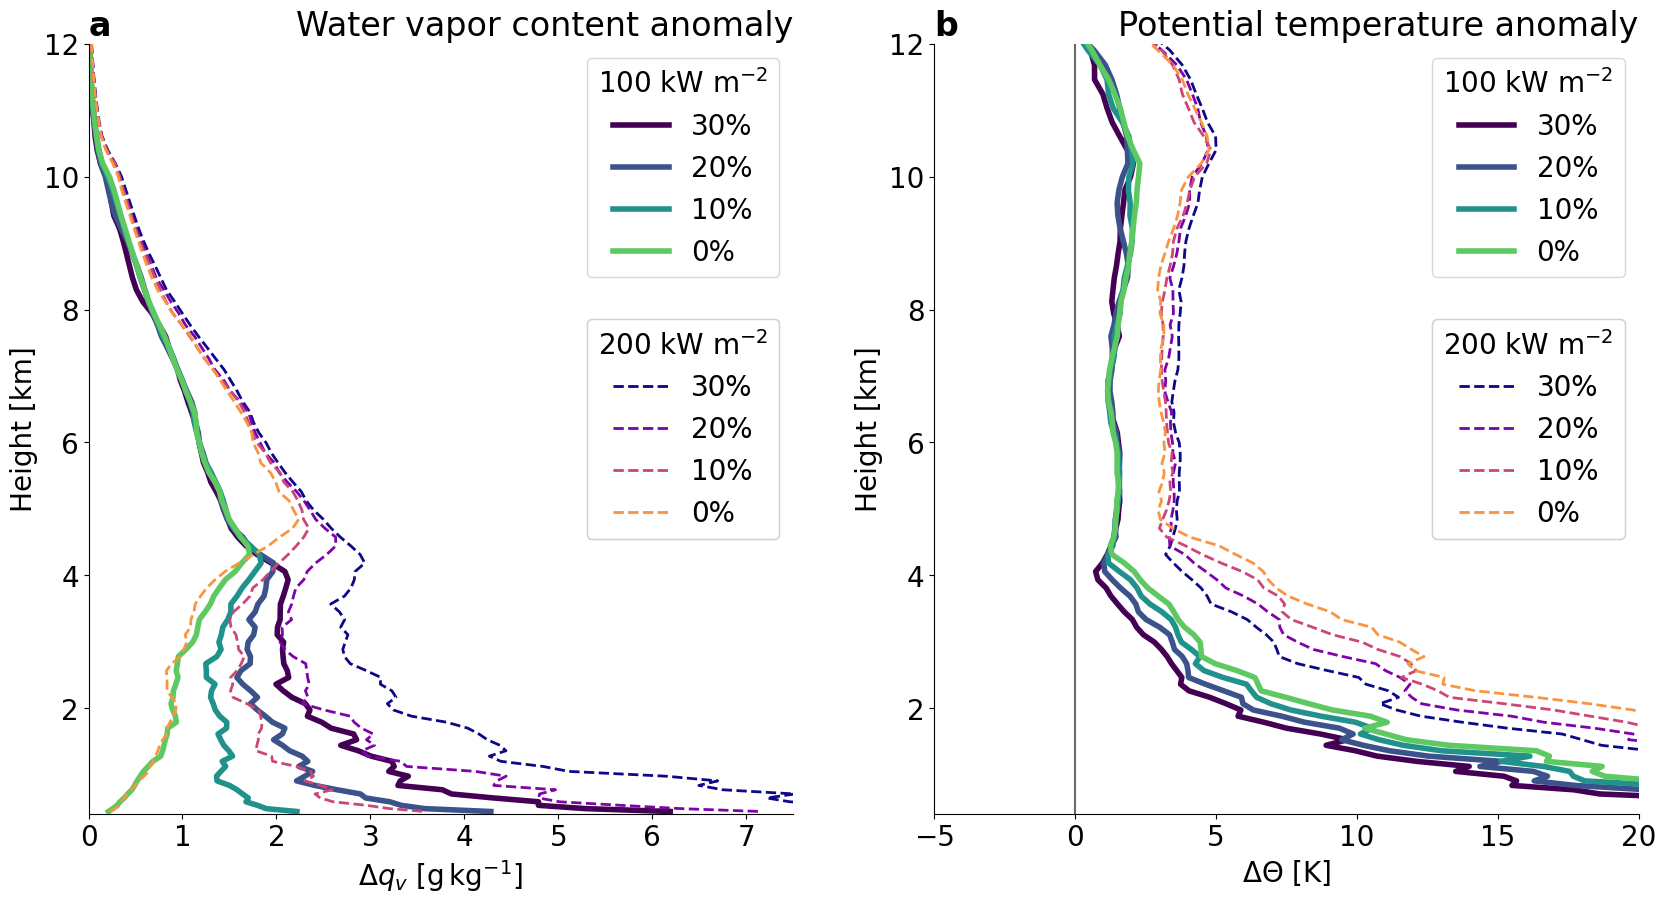

In [6]:
# Parameters for the plots
y_ticks = np.arange(2,14, 2)
colormap_1 = plt.cm.viridis
colormap_2 = plt.cm.plasma

# Generate color lists for plotting
colors_1 = [colormap_1(i / len(list100)) for i in range(len(list100))]
colors_2 = [colormap_2(i / len(list200)) for i in range(len(list200))]

# Plot properties
ymin, ymax = z.min().values, 12
line_width_1 = 4
line_width_2 = 2
ref = dsref.mean(("lon", "lat"))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=[20, 10])
axes[0].set_title("a", loc="left", fontweight='bold')
axes[1].set_title("b", loc="left", fontweight='bold')

# Plot for Water vapor content anomaly (first subplot)
ax = axes[0]
handles_legend_1, labels_legend_1 = [], []
handles_legend_2, labels_legend_2 = [], []

for i, ds in enumerate(list100):
    values = 1000 * (ds["qv"].where(ds.ao_mask).mean(("lon", "lat")).mean("time") - ref["qv"].values)
    line, = ax.plot(values, ds.height, color=colors_1[i], linewidth=line_width_1, label=set_names[i])
    handles_legend_1.append(line)
    labels_legend_1.append(set_names[i])

for i, ds in enumerate(list200):
    values = 1000 * (ds["qv"].where(ds.ao_mask).mean(("lon", "lat")).mean("time") - ref["qv"].values)
    line, = ax.plot(values, ds.height, color=colors_2[i], linewidth=line_width_2, linestyle="--", label=set_names[i])
    handles_legend_2.append(line)
    labels_legend_2.append(set_names[i])

# Customize the first subplot
ax.set_title("Water vapor content anomaly", loc="right")
ax.set_xlabel(r"$\Delta q_v$ [g$\,$kg$^{-1}$]")
ax.set_xlim(-0, 7.5)

# Add legends for the first plot
legend_1 = ax.legend(handles=handles_legend_1, labels=labels_legend_1, loc='upper right', title='100 kW m$^{-2}$')
ax.add_artist(legend_1)

legend_2 = ax.legend(handles=handles_legend_2, labels=labels_legend_2, loc='center right', title='200 kW m$^{-2}$')
ax.add_artist(legend_2)

# Plot for Potential temperature anomaly (second subplot)
ax = axes[1]
handles_legend_1, labels_legend_1 = [], []
handles_legend_2, labels_legend_2 = [], []

for i, ds in enumerate(list100):
    values = (ds["tpot"].where(ds.ao_mask).mean(("lon", "lat")).mean("time") - ref["tpot"].values)
    line, = ax.plot(values, ds.height, color=colors_1[i], linewidth=line_width_1, label=set_names[i])
    handles_legend_1.append(line)
    labels_legend_1.append(set_names[i])

for i, ds in enumerate(list200):
    values = (ds["tpot"].where(ds.ao_mask).mean(("lon", "lat")).mean("time") - ref["tpot"].values)
    line, = ax.plot(values, ds.height, color=colors_2[i], linewidth=line_width_2, linestyle="--", label=set_names[i])
    handles_legend_2.append(line)
    labels_legend_2.append(set_names[i])

# Customize the second subplot
ax.vlines(x=0, ymin=ymin, ymax=ymax, color="dimgrey")
ax.set_title("Potential temperature anomaly", loc="right")
ax.set_xlabel(r"$\Delta \Theta$ [K]")
ax.set_xlim(-5, 20)

# Add legends for the second plot
legend_1 = ax.legend(handles=handles_legend_1, labels=labels_legend_1, loc='upper right', title='100 kW m$^{-2}$')
ax.add_artist(legend_1)

legend_2 = ax.legend(handles=handles_legend_2, labels=labels_legend_2, loc='center right', title='200 kW m$^{-2}$')
ax.add_artist(legend_2)

# Apply consistent plot settings to both subplots
for ax in axes:
    ax.set_ylim(ymin, ymax)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks)
    ax.set_ylabel("Height [km]")
    sns.despine(ax=ax)

# Save the figure
my_path = "./figs/"
fig.savefig(my_path + 'fig09.png', dpi=300, bbox_inches='tight')
fig.savefig(my_path + 'fig09_lq.png', dpi=50, bbox_inches='tight')

plt.show()